In [455]:
import pandas as pd
import numpy as np
import openpyxl
import warnings
warnings.filterwarnings("ignore")
file_path = r"C:\Users\mrjoj\OneDrive\Desktop\008272 - Analyst Data Science - Technical Assessment - Data.xlsx"

In [463]:
workbook = openpyxl.load_workbook(file_path)
print(workbook.sheetnames)

['Dataset 1 - General', 'Dataset 2 - Underwriting', 'Data General T', 'Data Underwriting T', 'joined_data', 'TS_Data']


K-Means Clustering (Joined Data is picked after EDA)

In [487]:
joined_data = pd.read_excel(file_path,sheet_name='joined_data',index_col=[0])

In [488]:
### Selecting Columns of Interest

data_for_clustering = joined_data[['Mean GWP (£m)','Mean NWP (£m)','Mean SCR Ratio','Mean Gross Claims Incurred','Mean Net Combined Ratio','Mean Total Assets (£m)',
'Mean Total Liabilities','Mean EoF SCR']]

## Rounding up the ratios
data_for_clustering['Mean SCR Ratio'] = data_for_clustering['Mean SCR Ratio'].astype(float).round(2)
data_for_clustering['Mean EoF SCR'] = data_for_clustering['Mean EoF SCR'].astype(float).round(2)

In [541]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Load the data
df = data_for_clustering

# Scale the data using StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Define the k-means clustering pipeline
pipeline = Pipeline(steps=[('kmeans', KMeans())])

# Define the hyperparameter grid to search
param_grid = {'kmeans__n_clusters': np.arange(1,3)}

# Perform hyperparameter optimization using GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5)
grid.fit(df_scaled)

# Get the best number of clusters
n_clusters = grid.best_params_['kmeans__n_clusters']

# Train the k-means model with the best number of clusters
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(df_scaled)

# Predict the cluster labels
labels = kmeans.predict(df_scaled)

# Calculate the silhouette score
silhouette_score = silhouette_score(df_scaled, labels)
print("Silhouette score: {:.2f}".format(silhouette_score))

# Calculate the CH score
ch_score = calinski_harabasz_score(df_scaled, labels)
print("CH score: {:.2f}".format(ch_score))

Silhouette score: 0.65
CH score: 77.13


In [542]:
grid.best_params_['kmeans__n_clusters']

2

Random Forest Classifier

In [544]:
# Define the threshold for determining if a firm deviates significantly from the average
threshold = 0.25  # Increase the threshold as desired

# Calculate the mean and standard deviation of the columns "Mean GWP (£m)" and "Mean EoF SCR"
mean_gwp = np.mean(joined_data["Mean GWP (£m)"])
std_gwp = np.std(joined_data["Mean GWP (£m)"])

mean_ncr = np.mean(joined_data['Mean EoF SCR'])
std_ncr = np.std(joined_data['Mean EoF SCR'])

# Create a new column "Attention" based on the deviation of "Mean GWP (£m)" and "Mean EoF SCR" from their means
joined_data["Attention"] = np.where(((joined_data["Mean GWP (£m)"] - mean_gwp) > threshold * std_gwp) |
                                     ((joined_data['Mean EoF SCR'] - mean_ncr) > threshold * std_ncr), 1, 0)


In [545]:
data_for_random_forest = joined_data[['Mean GWP (£m)','Mean NWP (£m)','Mean SCR Ratio','Mean Gross Claims Incurred','Mean Net Combined Ratio','Mean Total Assets (£m)',
'Mean Total Liabilities','Mean EoF SCR','Mean Total Assets (£m)', 'Mean Total Liabilities','Mean BEL Inc TPs',
       'Mean Net BEL Inc TPs', 'Mean Pure Gross Claims Ratio',
       'Mean Net Expense Ratio', 'Mean Gross Expense Ratio',
       'Mean Gross Combined Ratio','Gross claims incurred (£m) to Gross claims incurred (£m).1',
       'Gross claims incurred (£m).1 to Gross claims incurred (£m).2',
       'Gross claims incurred (£m).2 to Gross claims incurred (£m).3',
       'Gross claims incurred (£m).3 to Gross claims incurred (£m).4',
       'GWP (£m).1 to GWP (£m).2', 'GWP (£m).2 to GWP (£m).3',
       'GWP (£m).3 to GWP (£m).4', 'NWP (£m)  to NWP (£m) .1',
       'NWP (£m) .1 to NWP (£m) .2', 'NWP (£m) .2 to NWP (£m) .3',
       'NWP (£m) .3 to NWP (£m) .4','Attention']]

In [546]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score4
from sklearn.model_selection import train_test_split


# Separate the features and target column
X = data_for_random_forest.drop('Attention', axis=1)
y = data_for_random_forest['Attention']

# Perform PCA on the dataset
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=0)

# Build the Random Forest Classifier
clf = RandomForestClassifier()

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 10,15],
    'min_samples_leaf': [1, 5,10,15]
}

# Perform hyperparameter optimization using GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Select the best hyperparameters
best_params = grid_search.best_params_

# Train the final Random Forest model using the best hyperparameters
clf = RandomForestClassifier(**best_params)
clf.fit(X_train, y_train)

# Evaluate the performance of the model on the test set
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Recall: {:.2f}%".format(recall*100))
print("F1 Score: {:.2f}%".format(f1*100))
print("AUC-ROC: {:.2f}%".format(auc*100))


Accuracy: 91.49%
Precision: 90.91%
Recall: 76.92%
F1 Score: 83.33%
AUC-ROC: 86.99%


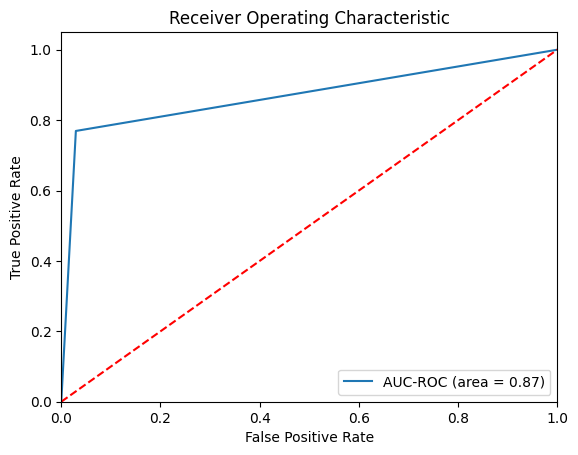

In [543]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate the AUC-ROC score
auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='AUC-ROC (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Time Series Analysis

In [373]:
workbook = openpyxl.load_workbook(file_path)
print(workbook.sheetnames)

['Dataset 1 - General', 'Dataset 2 - Underwriting', 'Data General T', 'Data Underwriting T', 'joined_data', 'TS_Data']


In [547]:
#Import the data from the specified sheet in the excel file
Joined_Time_Series_Sums_T = pd.read_excel(file_path,sheet_name='TS_Data')

#Remove the "YE" prefix from the "Year" column
Joined_Time_Series_Sums_T["Year"] = Joined_Time_Series_Sums_T["Year"].str.replace("YE", "")

#Store the dataframe in a new variable for convenience
df = Joined_Time_Series_Sums_T

#Convert the "Year" column to a datetime data type
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

#Set the "Year" column as the index of the dataframe
df.set_index('Year', inplace=True)

In [438]:
df

,NWP (£m),SCR (£m),EoF for SCR (£m),GWP (£m),Total assets (£m),Total liabilities (£m),Excess of assets over liabilities (£m) [= equity],Gross claims incurred (£m),"Gross BEL (inc. TPs as whole, pre-TMTP) (£m)","Net BEL (inc. TPs as a whole, pre-TMTP) (£m)",Pure net claims ratio,Net expense ratio,Net combined ratio,Pure gross claims ratio,Gross expense ratio,Gross combined ratio,SCR coverage ratio
Year,,,,,,,,,,,,,,,,,
2016-01-01,10685.823360,3812.152794,4322.730372,8397.010950,74091.469826,73141.645383,6138.401778,345.440421,741.150106,352.982604,1.330167,-0.188001,1.087582,-1.930133,-2.980283,0.600903,2.275550
2017-01-01,8690.424741,4294.846475,5230.192774,9169.191864,97917.453393,53161.165499,4754.285219,579.887486,931.347150,333.941161,0.480707,0.136255,0.708653,-11.354968,3.402069,-0.872693,2.031928
2018-01-01,9164.847266,2364.267811,4109.879042,13991.156185,93037.989772,96465.655153,4207.118497,399.109057,604.922123,589.696973,0.716776,0.248388,0.553604,0.729940,0.355900,1.163077,2.003561
2019-01-01,6682.809783,3095.754393,3460.572095,13047.727864,87272.664710,112524.737309,4057.849945,345.669982,545.952479,385.406833,0.349270,0.201126,0.886368,0.309178,0.220780,0.436496,2.771075
2020-01-01,10336.912394,3830.721679,6263.762775,11437.534289,75838.150987,84230.425605,4775.886796,237.839104,715.727675,418.357809,0.054513,0.310743,0.388036,-0.162699,0.200350,0.531347,1.928768


In [549]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

# Split the df into training and testing sets using 70-30 split
train_df = df[:int(len(df) * 0.7)]
test_df = df[int(len(df) * 0.7):]

# Extract the SCR column from the train_df
scr = train_df["SCR coverage ratio"]

# Scale the SCR column using Min-Max Scaler
scaler = MinMaxScaler()
scr = scaler.fit_transform(np.array(scr).reshape(-1,1))

# Train an ARIMA model on the scaled SCR df
model = ARIMA(scr, order=(1,1,0))
model_fit = model.fit()

# Predict the future values of SCR for multiple steps
num_steps = 5
future_values = model_fit.forecast(steps=num_steps)

# Invert the scaled prediction back to its original scale
future_values = scaler.inverse_transform(future_values[0].reshape(-1,1))

print("Predicted value:", future_values[0])
print("Actual value:", test_df["SCR coverage ratio"].iloc[0])

# Compare the predictions to the actual values in the test set



Predicted value: [1.99704272]
Actual value: 2.77107488041638


In [550]:
################################### END ###############################

In [ ]:
#big_firms = joined_data[['Firms']][joined_data['Attention']==1].reset_index(drop=True)
#data_general_TS = pd.read_excel(file_path,sheet_name='Dataset 1 - General',header=[0,1],index_col=[0])
#data_underwriting_TS = pd.read_excel(file_path,sheet_name='Dataset 2 - Underwriting',header=[0,1],index_col=[0])
#Time_Series_DG = data_general_TS.loc[big_firms['Firms']]
#Time_Series_UW = data_underwriting_TS.loc[big_firms['Firms']]
#Joined_Time_Series = Time_Series_DG.merge(Time_Series_UW,left_index=True, right_index=True,how='inner')
#Joined_Time_Series_Sums = pd.DataFrame(Joined_Time_Series.mean(axis=0),columns=['Mean Values'])